In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Install SPECFEM3D
Please refer to: https://github.com/SPECFEM/specfem3d

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import Image

from scipy.interpolate import griddata, splprep, splev
from scipy.ndimage import gaussian_filter
from scipy import signal

import utm

In [4]:
# Load topography
topo = np.loadtxt('ptopo.mean.utm')

# Extracting individual columns
lon = topo[:,0]
lat = topo[:,1]
elev = topo[:,2]

# Creating a grid to interpolate
lons = np.linspace(np.min(lon), np.max(lon), 200)
lats = np.linspace(np.min(lat), np.max(lat), 200)

# Interpolating elevation data
grid_lon, grid_lat = np.meshgrid(lons, lats)
grid_elev = griddata((lon, lat), elev, (grid_lon, grid_lat), method='cubic')

# Remove NaNs at the boundary using slicing
grid_elev[:5, :]  = grid_elev[ 5, None, :]
grid_elev[-5:, :] = grid_elev[-5, None, :]
grid_elev[:, :5]  = grid_elev[:,  5, None]
grid_elev[:, -5:] = grid_elev[:, -5, None]

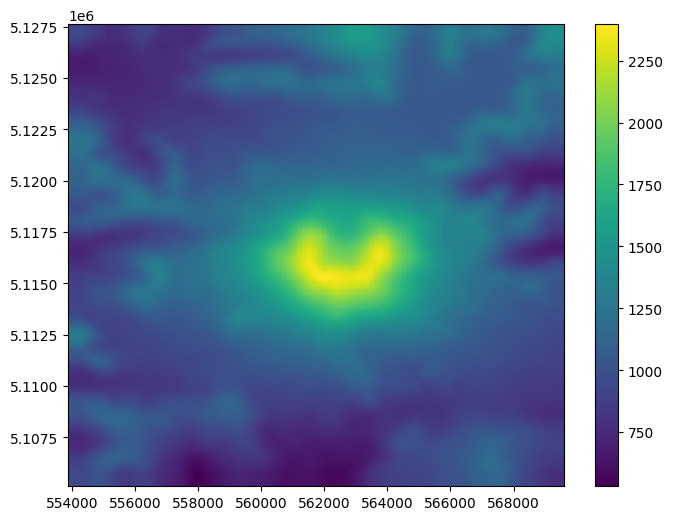

In [5]:
# Creating the plot
fig = plt.figure(figsize=(8, 6))
plt.pcolor(grid_lon, grid_lat, grid_elev)
plt.colorbar()
plt.show()

## Design the fiber cable trajectory

In [6]:
cable = []
max_elevation_idx = np.argmax(elev)
# cable.append([lon[max_elevation_idx-1], lat[max_elevation_idx-1]])
cable.append([lons[50*2], lats[45*2]])
cable.append([lons[47*2], lats[42*2]])
cable.append([lons[44*2], lats[40*2]])
cable.append([lons[40*2], lats[35*2]])
cable.append([lons[42*2], lats[30*2]])
cable.append([lons[48*2], lats[28*2]])
cable.append([lons[55*2], lats[27*2]])
cable.append([lons[60*2], lats[26*2]])
cable.append([lons[65*2], lats[25*2]])
cable.append([lons[70*2], lats[22*2]])
cable.append([lons[75*2], lats[19*2]])
cable.append([lons[80*2], lats[19*2]])
cable.append([lons[85*2], lats[20*2]])
cable.append([lons[90*2], lats[22*2]])
cable.append([lons[95*2], lats[24*2]])
# cable.append([lons[98*2], lats[26*2]])
cable = np.array(cable)

In [7]:
# Number of points to interpolate - more points mean a smoother curve
num_points = 2500

# Preparing the data for spline fitting (using all coordinates)
tck, _ = splprep([cable[:,0], cable[:,1]], s=0)

# Generating new, smoothed points from the spline representation
cable_smoothed = splev(np.linspace(0, 1, num_points), tck)

cable_smoothed = np.array(cable_smoothed).T

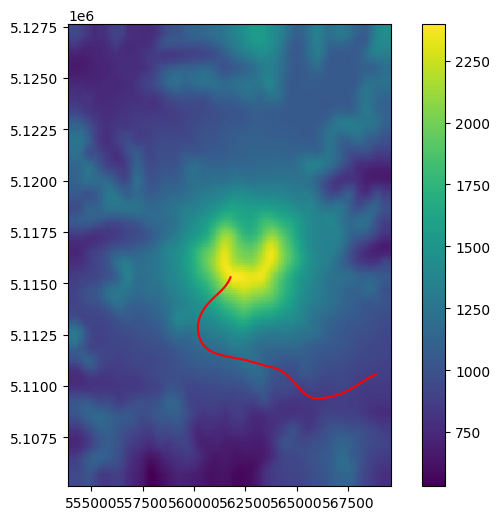

In [8]:
# Creating the plot
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolor(grid_lon, grid_lat, grid_elev)
ax.plot(cable_smoothed[:,0], cable_smoothed[:,1], '-r')
ax.set_aspect('equal')
plt.colorbar(cax)
plt.show()

## Elevation of the fiber cable

In [9]:
cable_elev = griddata((lon, lat), elev, (cable_smoothed[:,0], cable_smoothed[:,1]), method='cubic')

cable_coord = np.concatenate((cable_smoothed, cable_elev.reshape(-1,1)), axis=1)

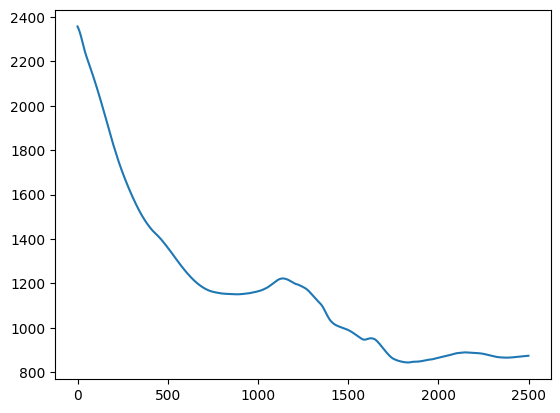

In [10]:
plt.plot(cable_elev)

## Plot the topography with the fiber cable

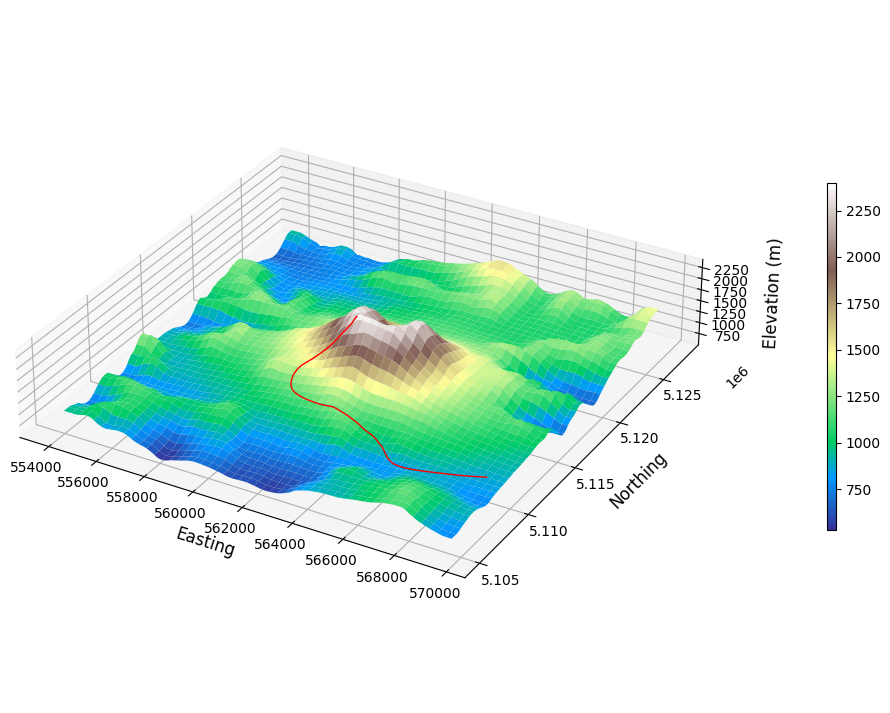

In [11]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

# Plotting the trajectory line first so it appears in front
ax.plot(cable_coord[:,0], cable_coord[:,1], cable_coord[:,2], color='red', linewidth=1, linestyle='-', zorder=5)

# Surface plot with colormap
surf = ax.plot_surface(grid_lon, grid_lat, grid_elev, cmap='terrain', vmin=grid_elev.min(), vmax=grid_elev.max(), zorder=0)

# Labels and title
ax.set_xlabel('Easting', fontsize=12, labelpad=8)
ax.set_ylabel('Northing', fontsize=12, labelpad=8)
ax.set_zlabel('Elevation (m)', fontsize=12, labelpad=8)
ax.set_box_aspect((1, 1, 0.2))  # Adjusted Z-axis for better visibility
plt.colorbar(surf, shrink=0.5, aspect=40, pad=0.1)

plt.show()

## Generic Cable

In [12]:
from GenericCable import GenericCable

In [13]:
traj = cable_coord.copy()
traj[:,2] = -traj[:,2]
# set large length for better plotting
chann_len = 20.0
chann_num = 679
gauge_len = 20.0

In [14]:
cable = GenericCable(traj, chann_len, chann_num, gauge_len)

Last channel length must be between 10.0 and 13584.32755709135 m, it is 13590.0 m
Change the channel number to 679 to make sure the last channel ends at the end of the cable


In [15]:
cable

DAS Cable Information: 
  Cable total length: 13594.33 m 
  Channel coverage: 10.00 - 13590.00 m 
  Channel interval: 20.00 m 
  Channel number: 679 
  Gauge length: 20.00 m 
  Max channel length error: 0.0179 m 
  Max  gauge  length error: 0.1691 m 


In [16]:
chan_coord = cable.get_chann_coords()

In [17]:
chan_coord.shape

(679, 3)

In [18]:
## Smooth the sensitivies
cable.tan_cha[:,0] = gaussian_filter(cable.tan_cha[:,0], sigma=2)
cable.tan_cha[:,1] = gaussian_filter(cable.tan_cha[:,1], sigma=2)
cable.tan_cha[:,2] = gaussian_filter(cable.tan_cha[:,2], sigma=2)

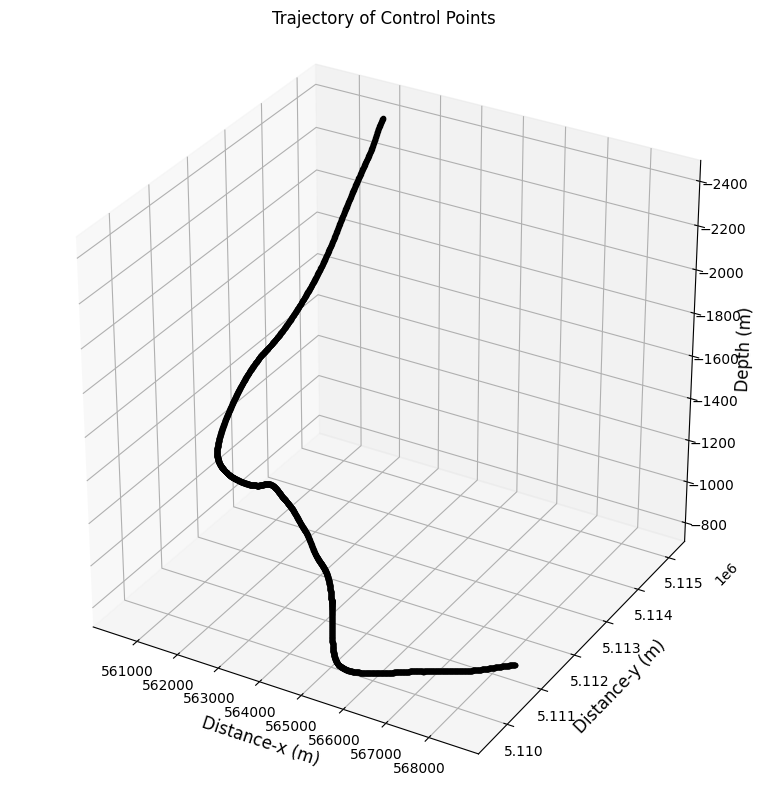

In [19]:
cable.plot_traj()

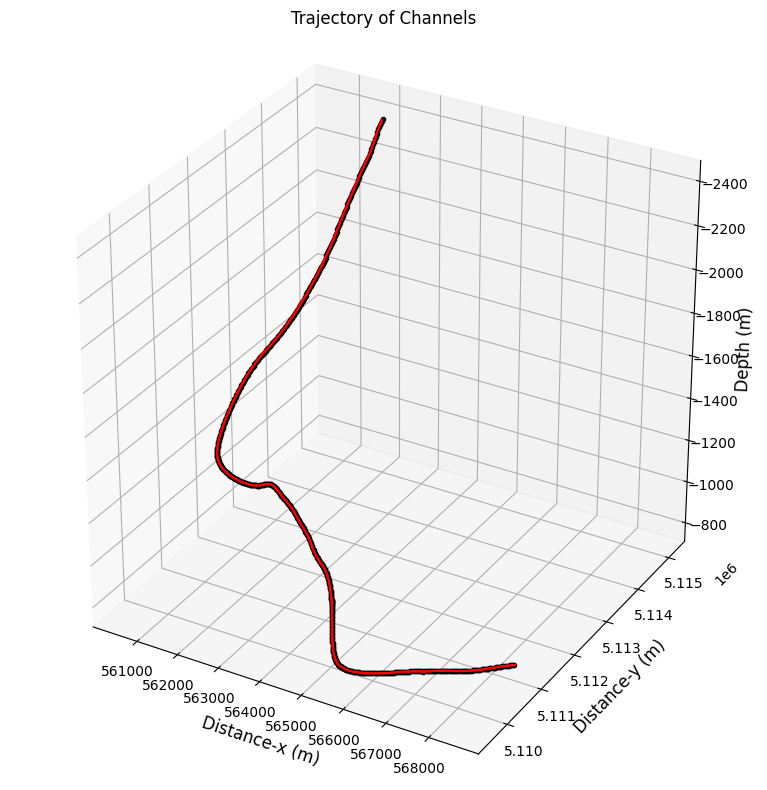

In [20]:
cable.plot_channel(show_tangent=True)

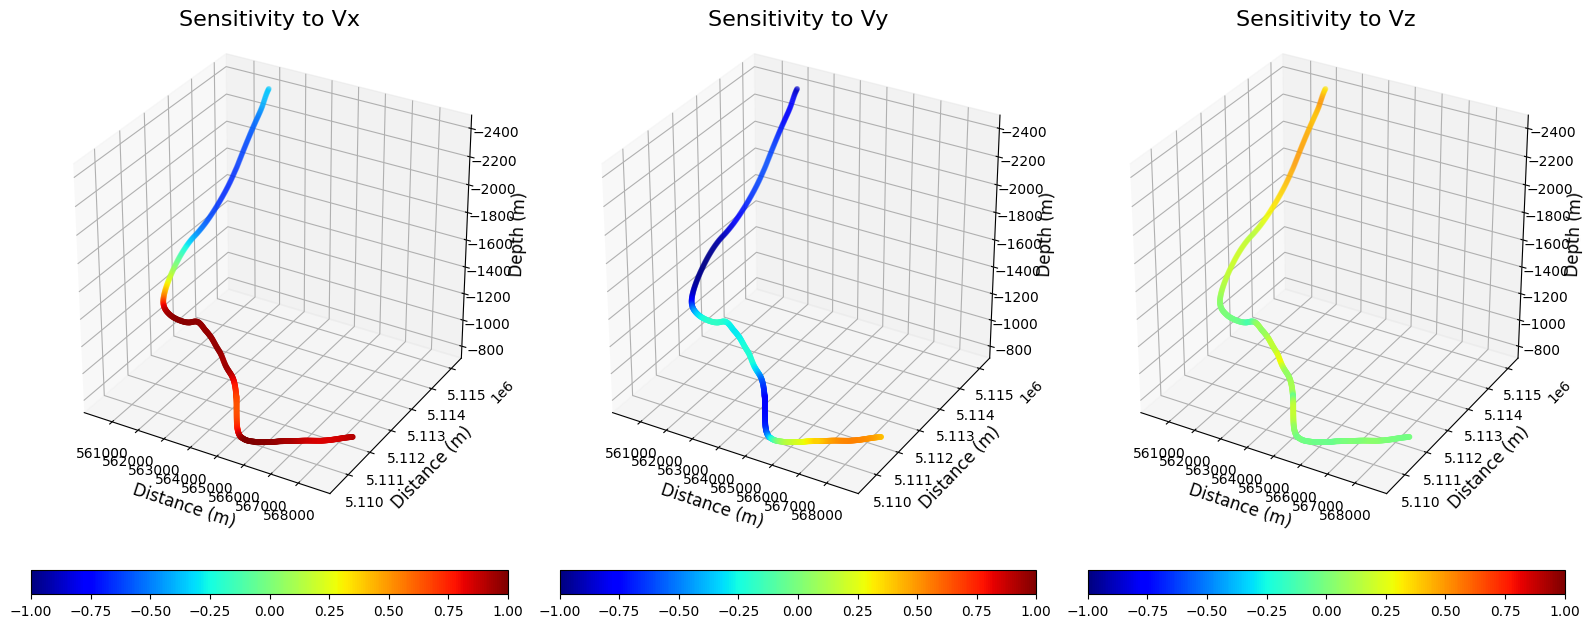

In [21]:
cable.plot_sensitivity()

/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000

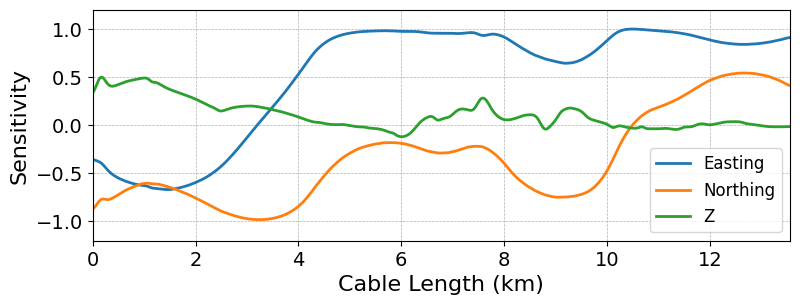

In [22]:
tan = cable.tan_cha
cha = cable.traj_cha

length = np.arange(chann_num) * chann_len / 1000

fig, ax = plt.subplots(figsize=(9, 3))

# Increase line width and use different line styles
ax.plot(length, tan[:,0], label='Easting',  linewidth=2, linestyle='-')
ax.plot(length, tan[:,1], label='Northing', linewidth=2, linestyle='-')
ax.plot(length, tan[:,2], label='Z',        linewidth=2, linestyle='-')

# Enhance labels and title
ax.set_xlabel('Cable Length (km)', fontsize=16)
ax.set_ylabel('Sensitivity', fontsize=16)

# Refine grid and axes
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim([min(length), max(length)])
ax.set_ylim([-1.2, 1.2])

# Improve the legend
ax.legend(frameon=True, loc='best', fontsize=12)

# Adjust font sizes
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust labelsize as needed

# Save the plot with high resolution
plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/2721740440.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/2721740440.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/2721740440.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/2

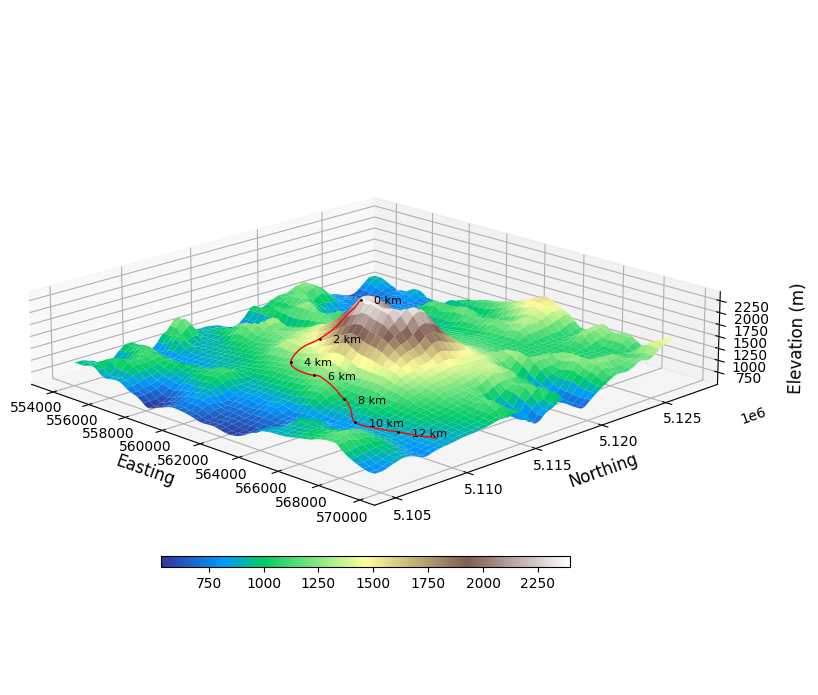

In [23]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the trajectory line
ax.plot(cable_coord[:,0], cable_coord[:,1], cable_coord[:,2], color='red', linewidth=1, linestyle='-', zorder=5)

# Surface plot with colormap
surf = ax.plot_surface(grid_lon, grid_lat, grid_elev, cmap='terrain', vmin=grid_elev.min(), vmax=grid_elev.max(), zorder=4)

# Plot some lables
chan_coord_plot = chan_coord[::100,:]
ax.plot(chan_coord_plot[:,0], chan_coord_plot[:,1], -chan_coord_plot[:,2], 'k.', markersize = 2, alpha=1.0, zorder=5)
for i in range(chan_coord_plot.shape[0]):
    ax.text(chan_coord_plot[i,0] + 700, chan_coord_plot[i,1], -chan_coord_plot[i,2], f'{i*2} km', fontsize=8, zorder=4)

# Labels and title
ax.set_xlabel('Easting', fontsize=12, labelpad=12)
ax.set_ylabel('Northing', fontsize=12, labelpad=12)
ax.set_zlabel('Elevation (m)', fontsize=12, labelpad=8)
ax.set_box_aspect((1, 1, 0.2))  # Adjusted Z-axis for better visibility
plt.colorbar(surf, shrink=0.35, aspect=40, pad=-0.20, orientation='horizontal')
ax.view_init(elev=18, azim=-45)

plt.tight_layout()
plt.savefig('topo.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/1343555137.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo2.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/1343555137.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo2.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/1343555137.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('topo2.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_161

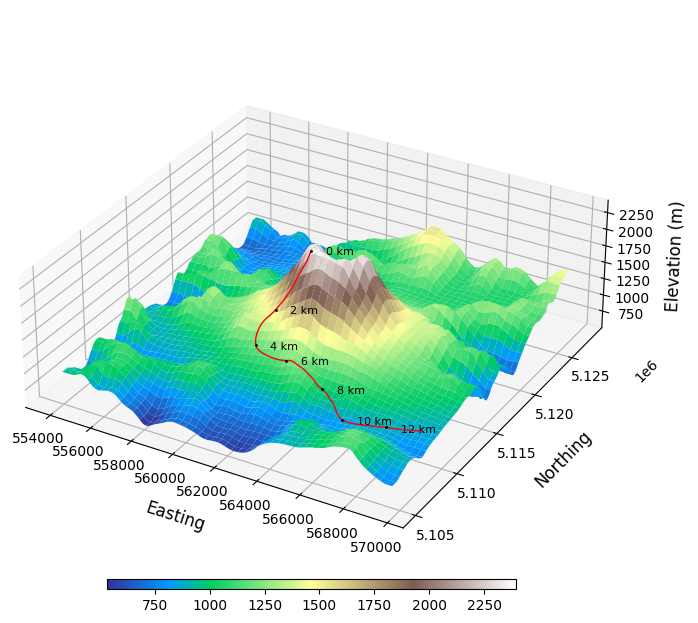

In [24]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the trajectory line
ax.plot(cable_coord[:,0], cable_coord[:,1], cable_coord[:,2], color='red', linewidth=1, linestyle='-', zorder=5)

# Surface plot with colormap
surf = ax.plot_surface(grid_lon, grid_lat, grid_elev, cmap='terrain', vmin=grid_elev.min(), vmax=grid_elev.max(), zorder=4)

# Plot some lables
chan_coord_plot = chan_coord[::100,:]
ax.plot(chan_coord_plot[:,0], chan_coord_plot[:,1], -chan_coord_plot[:,2], 'k.', markersize = 2, alpha=1.0, zorder=5)
for i in range(chan_coord_plot.shape[0]):
    ax.text(chan_coord_plot[i,0] + 700, chan_coord_plot[i,1], -chan_coord_plot[i,2], f'{i*2} km', fontsize=8, zorder=4)

# Labels and title
ax.set_xlabel('Easting', fontsize=12, labelpad=12)
ax.set_ylabel('Northing', fontsize=12, labelpad=12)
ax.set_zlabel('Elevation (m)', fontsize=12, labelpad=8)
ax.set_box_aspect((1, 1, 0.35))  # Adjusted Z-axis for better visibility
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust labelsize as needed

plt.colorbar(surf, shrink=0.35, aspect=40, pad=-0.05, orientation='horizontal')
# ax.view_init(elev=18, azim=-45)

plt.tight_layout()
plt.savefig('topo2.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# # Function to update the plot for each frame
# def update_plot(angle):
#     ax.view_init(elev=30, azim=angle)

# # Create figure and 3D axis
# fig = plt.figure(figsize=(16, 9))
# ax = fig.add_subplot(111, projection='3d')

# # Plotting the trajectory line
# ax.plot(cable_coord[:,0], cable_coord[:,1], cable_coord[:,2], color='red', linewidth=1, linestyle='-', zorder=5)

# # Surface plot with colormap
# surf = ax.plot_surface(grid_lon, grid_lat, grid_elev, cmap='terrain', vmin=grid_elev.min(), vmax=grid_elev.max(), zorder=4)

# # Plot some lables
# chan_coord_plot = chan_coord[::100,:]
# ax.plot(chan_coord_plot[:,0], chan_coord_plot[:,1], -chan_coord_plot[:,2], 'k.', markersize = 2, alpha=1.0, zorder=5)
# for i in range(chan_coord_plot.shape[0]):
#     ax.text(chan_coord_plot[i,0] + 700, chan_coord_plot[i,1], -chan_coord_plot[i,2], f'{i*2} km', fontsize=8, zorder=4)

# # Labels and title
# ax.set_xlabel('Easting', fontsize=12, labelpad=8)
# ax.set_ylabel('Northing', fontsize=12, labelpad=8)
# ax.set_zlabel('Elevation (m)', fontsize=12, labelpad=8)
# ax.set_box_aspect((1, 1, 0.28))  # Adjusted Z-axis for better visibility
# plt.colorbar(surf, shrink=0.5, aspect=40, pad=0.1)

# plt.show()
# # Your plotting code here (plotting trajectory line, labels, surface plot, etc.)

# # Animation
# ani = animation.FuncAnimation(fig, update_plot, frames=np.arange(0, 360, 1), interval=50)
# ani.save('3d_plot_animation.gif', writer='imagemagick')

# plt.close(fig) # Prevents duplicate display of the last frame

In [26]:
cable.dot_product_test()

********************************************** 
Dot-product test: 
  Input waveform comp: vel, DAS comp: strain_rate 
  lhs = 1.72318584e+00 
  rhs = 1.72318584e+00 
  absolute error = 1.77635684e-15 
  relative error = 1.03085622e-15 

********************************************** 
Dot-product test: 
  Input waveform comp: vel, DAS comp: strain 
  lhs = 8.59621110e-02 
  rhs = 8.59621110e-02 
  absolute error = 1.52655666e-16 
  relative error = 1.77584827e-15 

********************************************** 
Dot-product test: 
  Input waveform comp: disp, DAS comp: strain_rate 
  lhs = 2.52891744e+03 
  rhs = 2.52891744e+03 
  absolute error = 1.04591891e-11 
  relative error = 4.13583650e-15 

********************************************** 
Dot-product test: 
  Input waveform comp: disp, DAS comp: strain 
  lhs = -5.49007559e-02 
  rhs = -5.49007559e-02 
  absolute error = 1.10744747e-14 
  relative error = 2.01718073e-13 



In [27]:
rec_loc = cable.get_rec_loc_unique()

In [28]:
rec_loc_lonlat = []
for i in range(rec_loc.shape[0]):
    # This area is coded by 10T, see: http://www.jaworski.ca/utmzones.htm
    rec_loc_lonlat.append(utm.to_latlon(rec_loc[i,0],  rec_loc[i,1], 10, zone_letter='T'))

rec_loc_lonlat = np.array(rec_loc_lonlat)

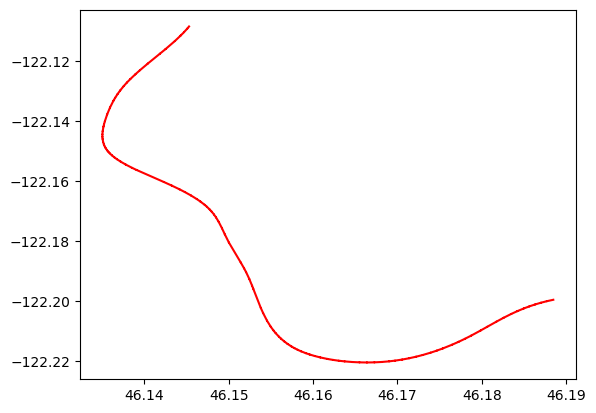

In [29]:
plt.plot(rec_loc_lonlat[:, 0], rec_loc_lonlat[:, 1], '-r')

## Write the station file for SPECFEM3D

In [30]:
with open('STATIONS', 'w') as file:
    # Iterate over the points, the topography is not needed
    for i in range(rec_loc_lonlat.shape[0]):
        lon = rec_loc_lonlat[i,0]
        lat = rec_loc_lonlat[i,1]
        file.write(f"STA{i+1:03} \t DAS \t {lon:.4f} \t {lat:.4f} \t 0.0 \t 0.0\n")

### Check the receiver information from the SPECFEM code

In [31]:
def load_vtk_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Find the start of the points data
    start_idx = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('POINTS'):
            start_idx = i + 1
            break
    
    # Read the points data
    start_idx += 1 # the first location is the source
    points_data = lines[start_idx:-1]
    points = [list(map(float, line.split())) for line in points_data]
    return np.array(points)

In [32]:
rec_specfem = load_vtk_file("sr.vtk")

In [33]:
rec_loc_lonlat.shape

(1358, 2)

In [34]:
rec_specfem.shape

(1358, 3)

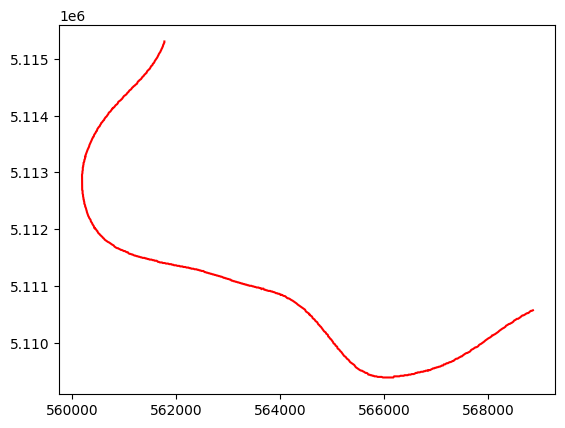

In [35]:
plt.plot(rec_specfem[:, 0], rec_specfem[:, 1], '-r')

In [36]:
rec_loc.shape

(1358, 3)

In [37]:
rec_specfem.shape

(1358, 3)

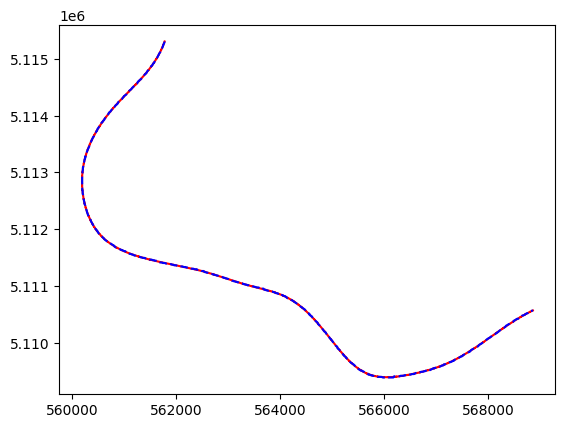

In [38]:
plt.plot(rec_loc[:, 0], rec_loc[:, 1], '-r')
plt.plot(rec_specfem[:, 0], rec_specfem[:, 1], '--b')

In [39]:
# # plt.scatter(rec_loc[:,0], rec_loc[:,1], c = rec_loc[:,2])
# plt.scatter(rec_specfem[:,0], rec_specfem[:,1], c = rec_loc[:,2] + rec_specfem[:,2])

# plt.colorbar()

(array([  3.,   4.,   2.,   6.,  12.,  77., 288., 688., 244.,  34.]),
 array([-53.19405273, -46.00231318, -38.81057363, -31.61883407,
        -24.42709452, -17.23535497, -10.04361541,  -2.85187586,
          4.33986369,  11.53160325,  18.7233428 ]),
 <BarContainer object of 10 artists>)

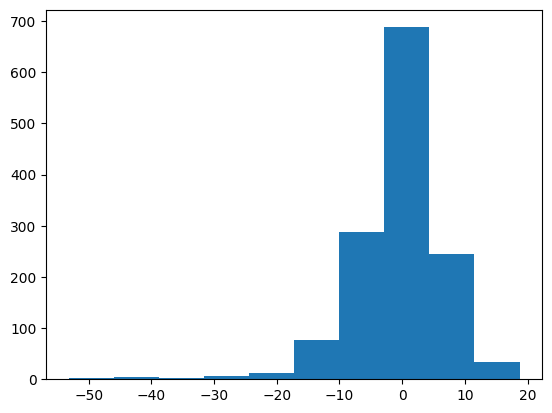

In [40]:
plt.hist(rec_loc[:,2] + rec_specfem[:,2])

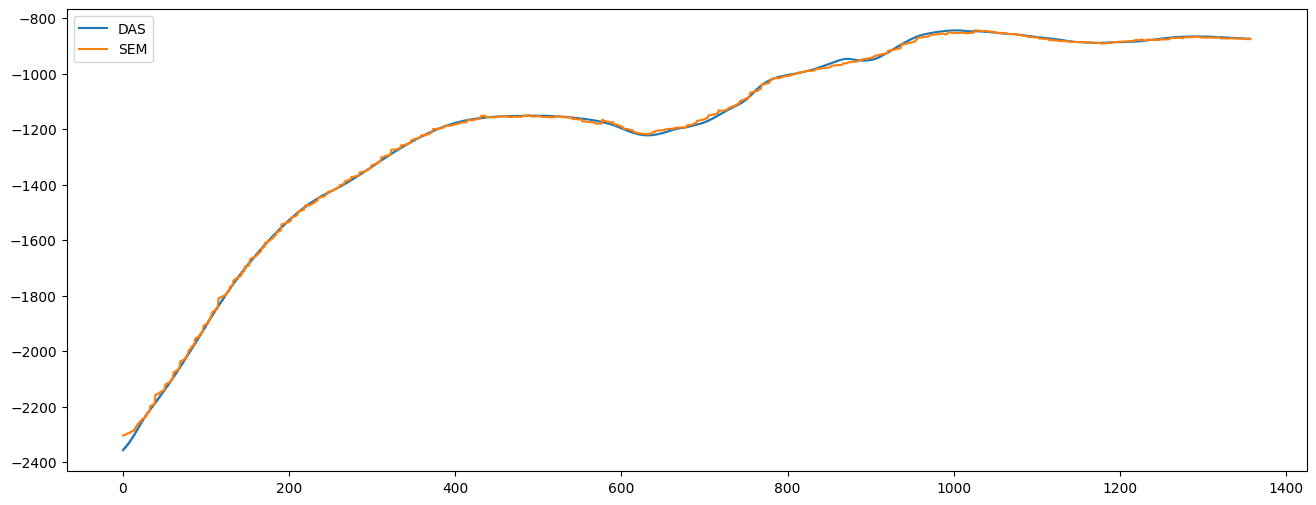

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(rec_loc[:,2], label='DAS')
plt.plot(-rec_specfem[:,2], label='SEM')
# plt.xlim([400, 600])
# plt.ylim([-1300, -1050])
plt.legend()
plt.show()

In [42]:
nrec = rec_loc.shape[0]

In [43]:
nrec

1358

## DAS waveform

In [44]:
data_vx = []
data_vy = []
data_vz = []

for i in range(nrec):
    # double check the comp
    vx = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXE.semv")
    vy = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXN.semv")
    vz = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXZ.semv")
    tt = vz[:,0]
    data_vx.append(vx[:,1])
    data_vy.append(vy[:,1])
    data_vz.append(vz[:,1])

t = tt - tt[0]
data_vel = np.array([data_vx, data_vy, data_vz])

In [45]:
# data_ux = []
# data_uy = []
# data_uz = []

# for i in range(nrec):
#     # double check the comp
#     ux = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXE.semd")
#     uy = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXN.semd")
#     uz = np.loadtxt(f"./OUTPUT_FILES/DAS.STA{i+1:03}.HXZ.semd")
#     t = uz[:,0]
#     data_vx.append(ux[:,1])
#     data_vy.append(uy[:,1])
#     data_vz.append(uz[:,1])

# data_dis = np.array([data_ux, data_uy, data_uz])

In [46]:
data_vel.shape

(3, 1358, 6000)

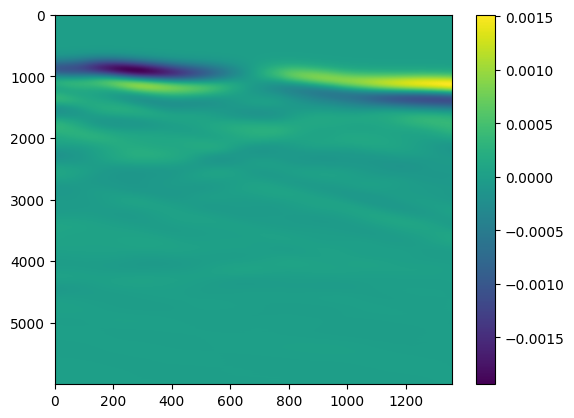

In [47]:
plt.imshow(data_vel[0,:,:].T, aspect='auto')
plt.colorbar()

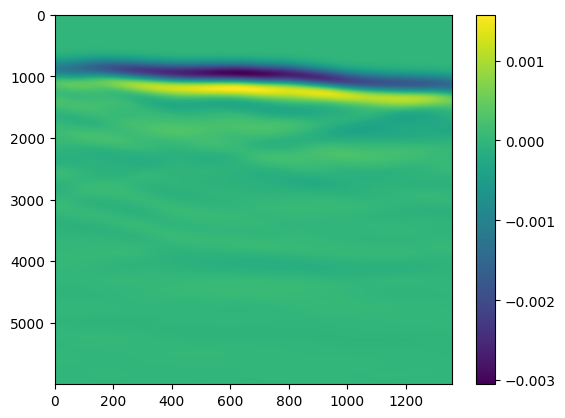

In [48]:
plt.imshow(data_vel[1,:,:].T, aspect='auto')
plt.colorbar()

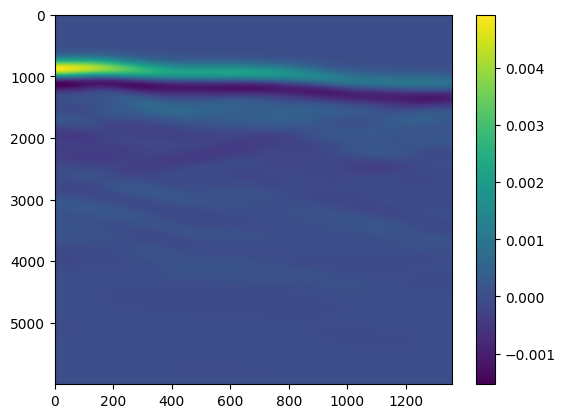

In [49]:
plt.imshow(data_vel[2,:,:].T, aspect='auto')
plt.colorbar()

In [50]:
data_das = cable.forward(data_vel, m_comp='vel', d_comp = 'strain_rate')

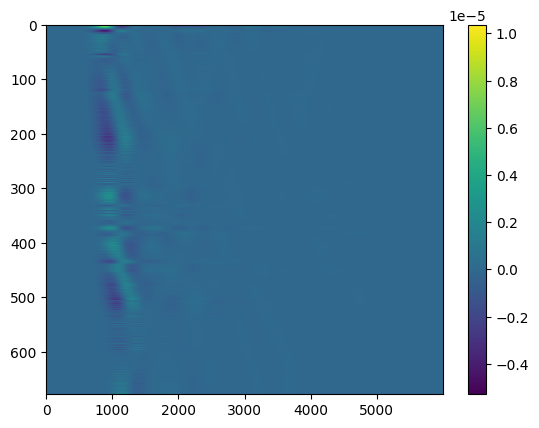

In [51]:
plt.imshow(data_das, aspect='auto')
plt.colorbar()

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wiggle(data, t, scale=1.0):
    """
    Plots a wiggle plot for seismic data.

    Parameters:
    data (2D numpy array): The seismic data array.
    scale (float): Scale factor for the amplitudes.
    """
    n_channels, n_times = data.shape
    fig = plt.figure(figsize=(12, 9))

    for i, trace in enumerate(data):
        trace = trace * scale + i
        plt.plot(trace, range(n_times), color='black', linewidth=1.0)
        plt.fill_betweenx(range(n_times), i, trace, where=(trace > i), color='black')

    plt.ylabel('Time')
    plt.xlabel('Channel Index')
    plt.gca().invert_yaxis()  # Inverts the y-axis to match seismic plot conventions
    plt.show()


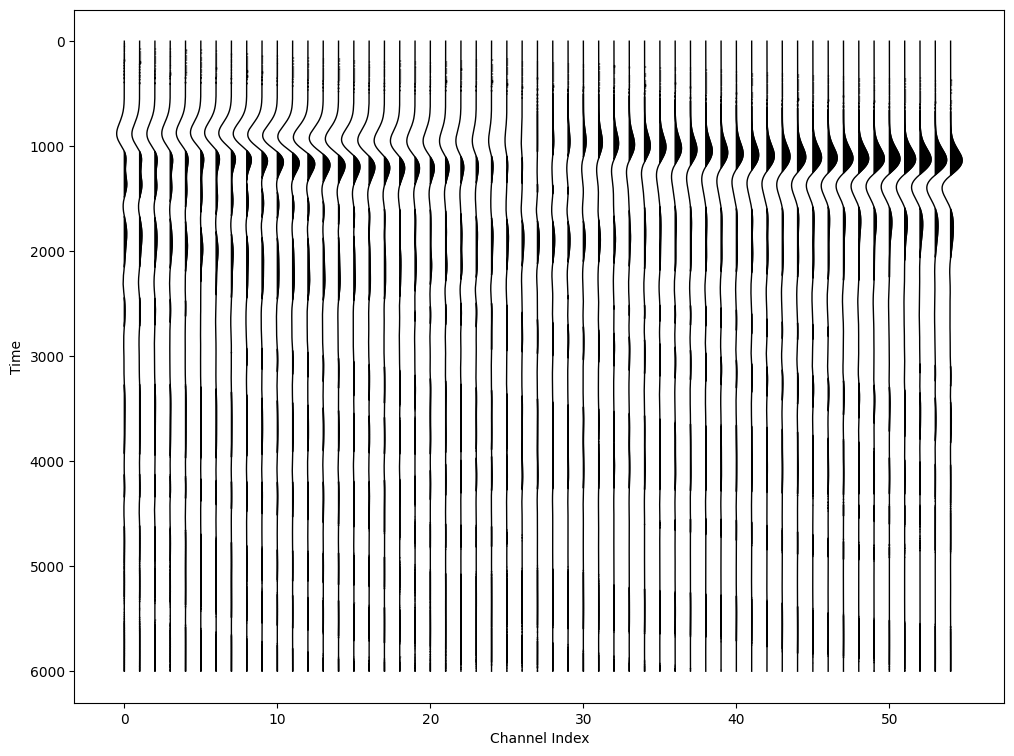

In [53]:
plot_wiggle(data_vel[0,::25,:], t, scale = 5e2)

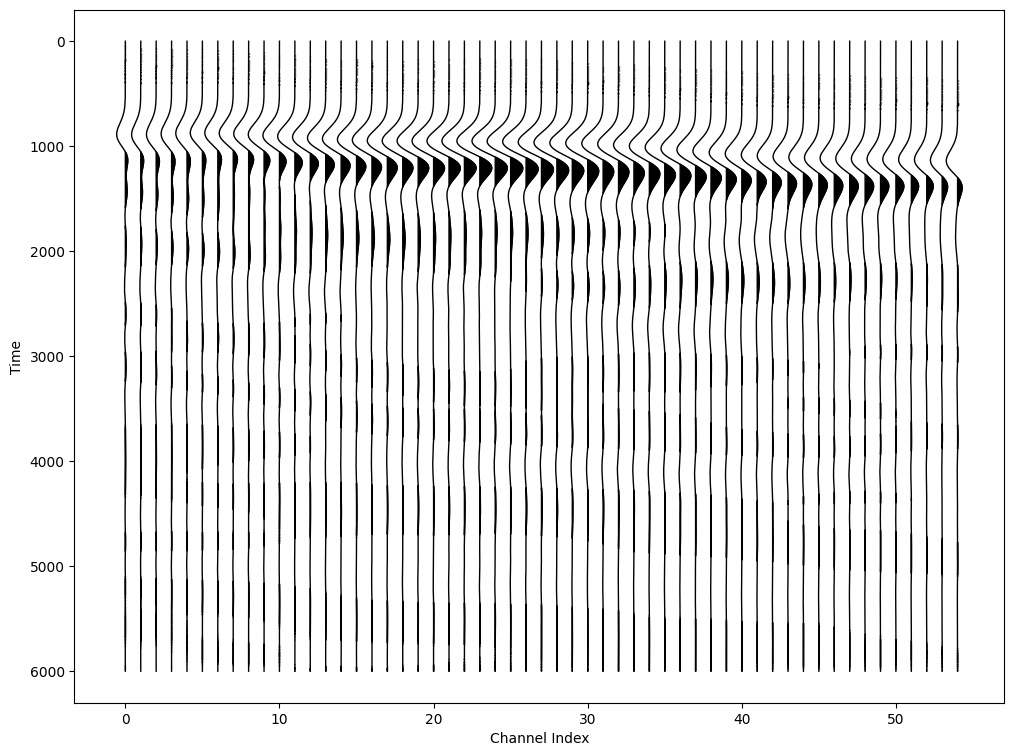

In [54]:
plot_wiggle(data_vel[1,::25,:], t, scale = 5e2)

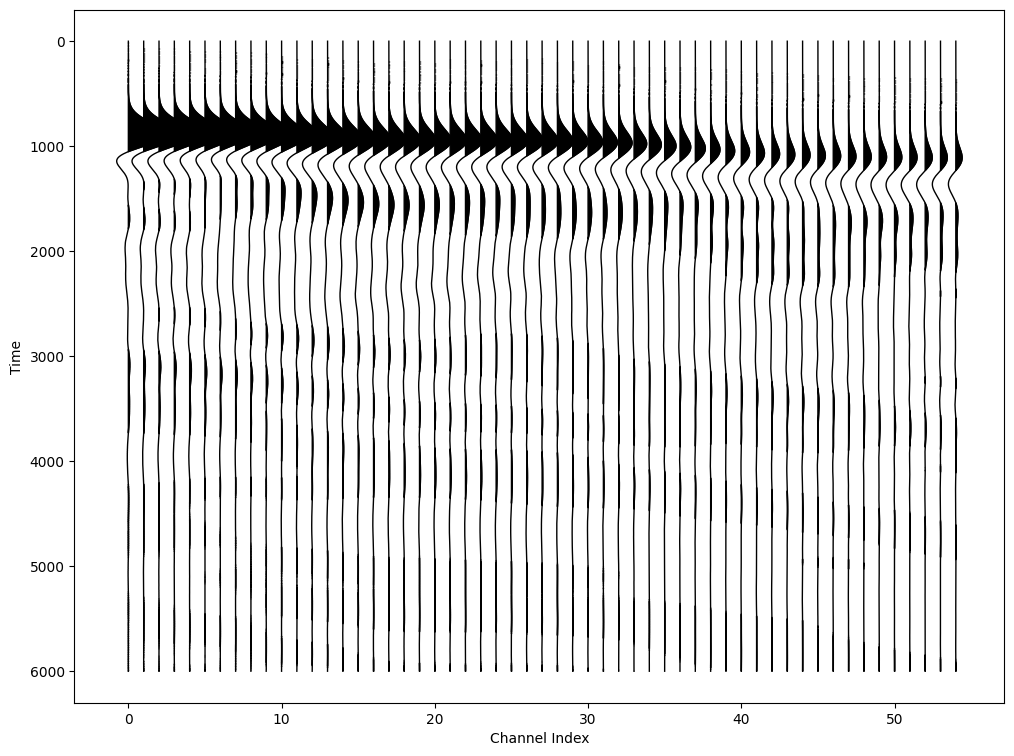

In [55]:
plot_wiggle(data_vel[2,::25,:], t, scale = 5e2)

/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/3050273667.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000

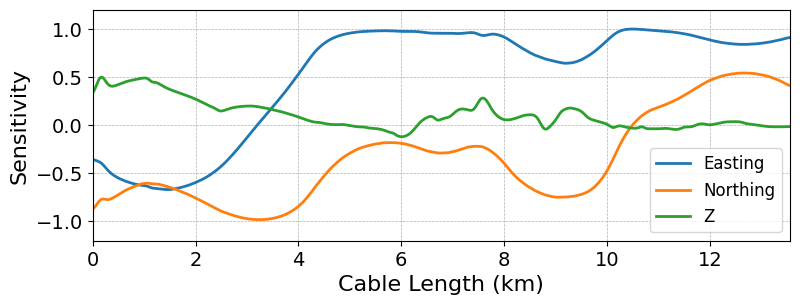

In [56]:
tan = cable.tan_cha
cha = cable.traj_cha

length = np.arange(chann_num) * chann_len / 1000

fig, ax = plt.subplots(figsize=(9, 3))

# Increase line width and use different line styles
ax.plot(length, tan[:,0], label='Easting',  linewidth=2, linestyle='-')
ax.plot(length, tan[:,1], label='Northing', linewidth=2, linestyle='-')
ax.plot(length, tan[:,2], label='Z',        linewidth=2, linestyle='-')

# Enhance labels and title
ax.set_xlabel('Cable Length (km)', fontsize=16)
ax.set_ylabel('Sensitivity', fontsize=16)

# Refine grid and axes
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim([min(length), max(length)])
ax.set_ylim([-1.2, 1.2])

# Improve the legend
ax.legend(frameon=True, loc='best', fontsize=12)

# Adjust font sizes
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust labelsize as needed

# Save the plot with high resolution
plt.savefig('sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


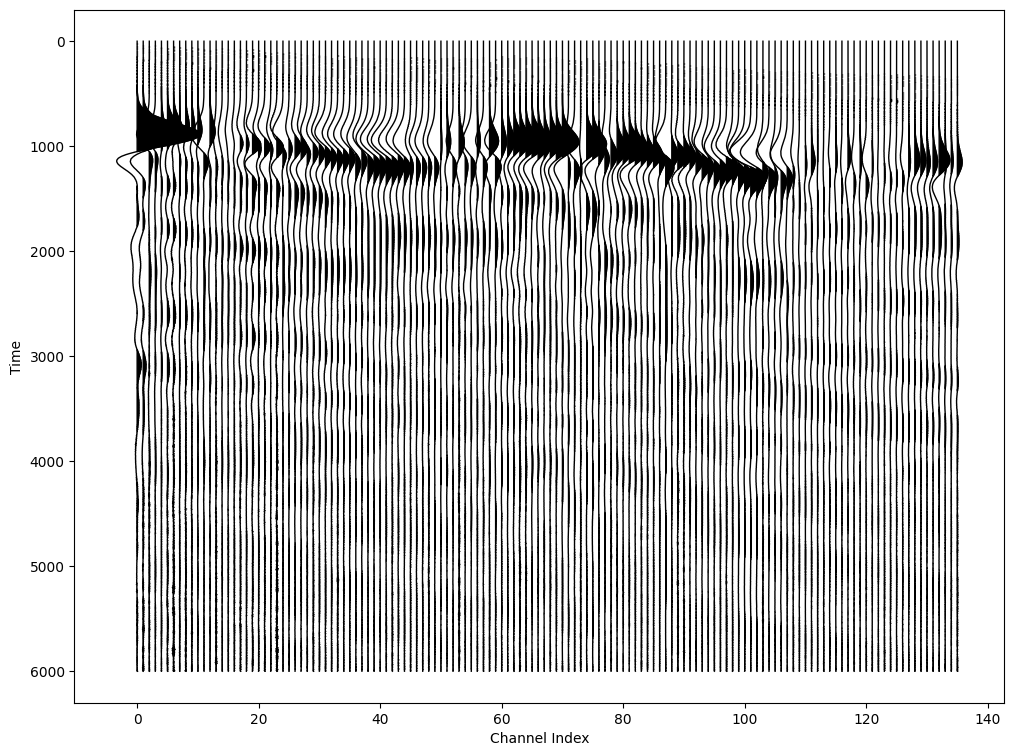

In [57]:
plot_wiggle(data_das[::5,:], t, scale = 1e6)

/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/4204208879.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('waveform.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/4204208879.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('waveform.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_1610/4204208879.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('waveform.png', dpi=300, bbox_inches='tight')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipyk

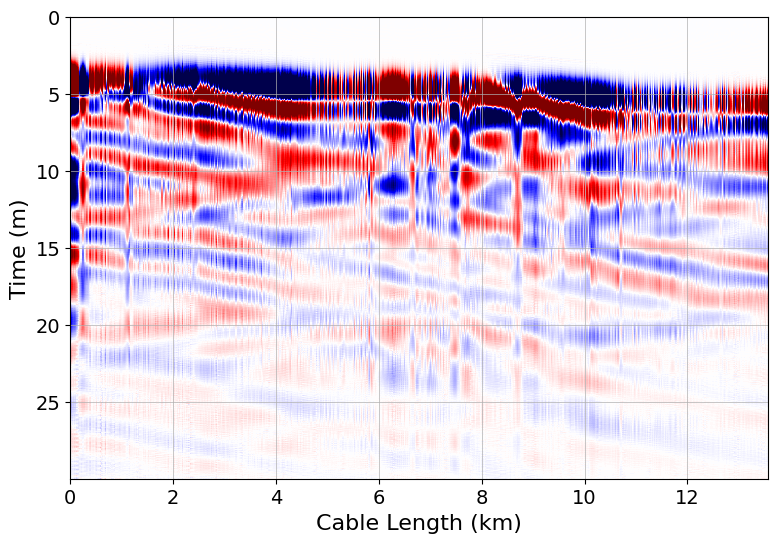

In [58]:
extent = [length[0], length[-1], t[-1], t[0]]

vmax = data_das.max() * 0.05

fig, ax = plt.subplots(figsize=(9, 6))
plt.imshow(data_das.T, aspect='auto', extent=extent, cmap='seismic', vmin=-vmax, vmax=vmax)
ax.set_xlabel('Cable Length (km)', fontsize=16)
ax.set_ylabel('Time (m)', fontsize=16)
# Refine grid and axes
ax.grid(True, which='both', linestyle='-', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust labelsize as needed

# Save the plot with high resolution
plt.savefig('waveform.png', dpi=300, bbox_inches='tight')
plt.show()


In [59]:
t

array([0.00000000e+00, 5.00011000e-03, 9.99999000e-03, ...,
       2.99850006e+01, 2.99899998e+01, 2.99950008e+01])